In [1]:
import torch as t
t.cuda.is_available()

True

In [2]:
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
import numpy as np

In [3]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, parser='auto')
X = X.values
y = y.astype(int).values

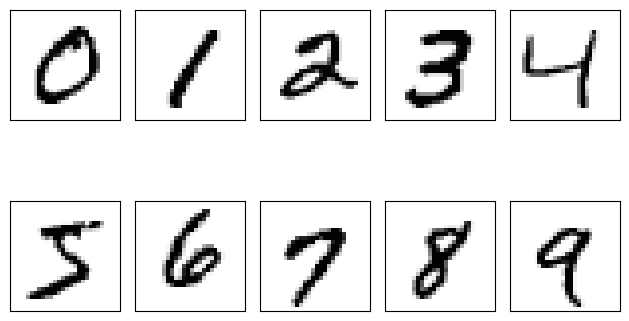

In [4]:
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X[y == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
#plt.savefig('figures/11_4.png', dpi=300)
plt.show()

In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X)
X

array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ...,
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.]])

In [6]:
import torch as t
from sklearn.model_selection import train_test_split

# 80% train; 10% validation; 10% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

X_train = t.tensor(X_train, dtype=t.float32)
y_train = t.tensor(y_train, dtype=t.long)
X_val = t.tensor(X_val, dtype=t.float32)
y_val = t.tensor(y_val, dtype=t.long)
X_test = t.tensor(X_test, dtype=t.float32)
y_test = t.tensor(y_test, dtype=t.long)

print(f"Training set  : X-{X_train.shape}, y-{y_train.shape}")
print(f"Validation set: X-{X_val.shape}, y-{y_val.shape}")
print(f"Test set      : X-{X_test.shape}, y-{y_test.shape}")

Training set  : X-torch.Size([56000, 784]), y-torch.Size([56000])
Validation set: X-torch.Size([7000, 784]), y-torch.Size([7000])
Test set      : X-torch.Size([7000, 784]), y-torch.Size([7000])


In [7]:
import math
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = Net()

if t.cuda.is_available():
    device = t.device("cuda")
    print("Running on CUDA GPU")
elif t.backends.mps.is_available():
    device = t.device("mps")
    print("Running on MPS GPU")
else:
    device = t.device("cpu")
    print("Running on CPU")

net.to(device)

Running on CUDA GPU


Net(
  (fc1): Linear(in_features=784, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [8]:
# loss_function = nn.CrossEntropyLoss()
loss_function = F.cross_entropy

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=64, shuffle=False)

total_batches = len(train_loader)
print(f"Total batches: {total_batches}")
log_interval = max(1, math.floor(total_batches / 20))
print(f"Log interval : every {log_interval} batches")

train_losses = []
val_losses = []

Total batches: 875
Log interval : every 43 batches


In [9]:
def train(optimizer, epochs=5):
    """
    Trains the network for the specified number of epochs.

    Appends the training and validation losses to the train_losses and val_losses lists defined
    outside the function.
    """
    for epoch in range(epochs):  # loop over the dataset multiple times
        running_training_loss = 0
        total_train_samples = 0
        net.train()  # Set the network to training mode
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass
            outputs = net(inputs)
            loss = loss_function(outputs, labels)
            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # weighted average of the training loss
            running_training_loss += loss.item() * inputs.shape[0]
            total_train_samples += inputs.shape[0]
            # Log at the specified interval
            if (i + 1) % log_interval == 0 or i == 0 or i == total_batches - 1:
                # Training loss
                avg_training_loss = running_training_loss / total_train_samples
                train_losses.append(avg_training_loss)
                # Validation loss
                net.eval()  # Set the network to evaluation mode
                # weighted average of the validation loss
                running_val_loss = 0
                total_val_samples = 0
                with t.no_grad():
                    for val_data in val_loader:
                        inputs, labels = data[0].to(device), data[1].to(device)
                        outputs = net(inputs)
                        val_loss = loss_function(outputs, labels)
                        running_val_loss += val_loss.item() * inputs.shape[0]
                        total_val_samples += inputs.shape[0]
                avg_val_loss = running_val_loss / total_val_samples
                val_losses.append(avg_val_loss)
                net.train()  # Set the network back to training mode

                print(f'[{epoch + 1}, {i + 1}] avg training loss: {avg_training_loss:.3f}, avg validation loss: {avg_val_loss:.3f}')
                running_training_loss = 0
                total_train_samples = 0
    # Plot the training and validation losses
    plt.plot(train_losses, label='Training loss')
    plt.plot(val_losses, label='Validation loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

[1, 1] avg training loss: 2.378, avg validation loss: 2.053
[1, 43] avg training loss: 1.007, avg validation loss: 0.470
[1, 86] avg training loss: 0.491, avg validation loss: 0.662
[1, 129] avg training loss: 0.425, avg validation loss: 0.348
[1, 172] avg training loss: 0.382, avg validation loss: 0.429
[1, 215] avg training loss: 0.352, avg validation loss: 0.335
[1, 258] avg training loss: 0.305, avg validation loss: 0.408
[1, 301] avg training loss: 0.346, avg validation loss: 0.445
[1, 344] avg training loss: 0.304, avg validation loss: 0.210
[1, 387] avg training loss: 0.309, avg validation loss: 0.282
[1, 430] avg training loss: 0.274, avg validation loss: 0.128
[1, 473] avg training loss: 0.278, avg validation loss: 0.178
[1, 516] avg training loss: 0.231, avg validation loss: 0.167
[1, 559] avg training loss: 0.238, avg validation loss: 0.235
[1, 602] avg training loss: 0.238, avg validation loss: 0.185
[1, 645] avg training loss: 0.192, avg validation loss: 0.250
[1, 688] avg

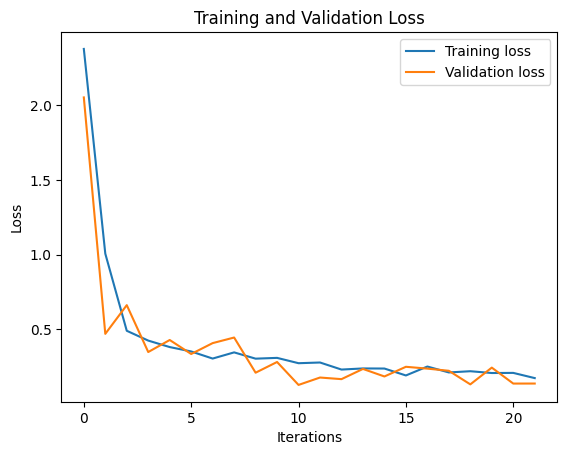

In [10]:
train(optim.Adam(net.parameters(), lr=0.001), epochs=1)

[1, 1] avg training loss: 0.116, avg validation loss: 0.099
[1, 43] avg training loss: 0.181, avg validation loss: 0.135
[1, 86] avg training loss: 0.195, avg validation loss: 0.204
[1, 129] avg training loss: 0.172, avg validation loss: 0.234
[1, 172] avg training loss: 0.171, avg validation loss: 0.226
[1, 215] avg training loss: 0.153, avg validation loss: 0.151
[1, 258] avg training loss: 0.149, avg validation loss: 0.117
[1, 301] avg training loss: 0.159, avg validation loss: 0.093
[1, 344] avg training loss: 0.137, avg validation loss: 0.104
[1, 387] avg training loss: 0.166, avg validation loss: 0.234
[1, 430] avg training loss: 0.147, avg validation loss: 0.080
[1, 473] avg training loss: 0.143, avg validation loss: 0.249
[1, 516] avg training loss: 0.119, avg validation loss: 0.068
[1, 559] avg training loss: 0.142, avg validation loss: 0.109
[1, 602] avg training loss: 0.141, avg validation loss: 0.055
[1, 645] avg training loss: 0.140, avg validation loss: 0.105
[1, 688] avg

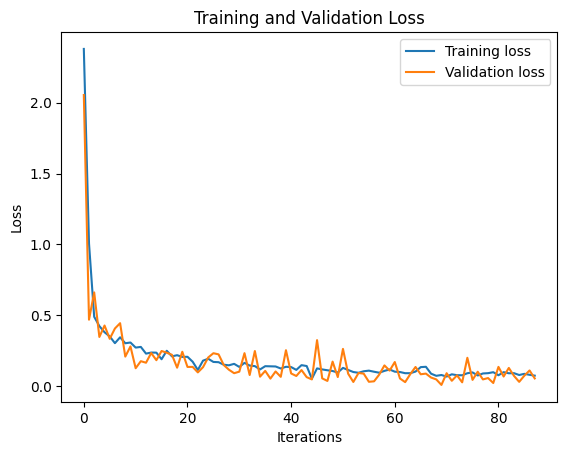

In [11]:
train(optim.Adam(net.parameters(), lr=0.001), epochs=3)

In [12]:
def calculate_test_loss():
    # test loss on the test set; do it in batches to avoid memory issues
    test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=10000, shuffle=False)
    running_test_loss = 0
    total_test_samples = 0
    with t.no_grad():
        for test_data in test_loader:
            inputs, labels = test_data[0].to(device), test_data[1].to(device)
            outputs = net(inputs)
            test_loss = loss_function(outputs, labels)
            running_test_loss += test_loss.item() * inputs.shape[0]
            total_test_samples += inputs.shape[0]
    avg_test_loss = running_test_loss / total_test_samples
    print(f'avg test loss: {avg_test_loss:.3f}')

calculate_test_loss()

avg test loss: 0.108


In [13]:
# generate predictions on the test set without loader
net.eval()
with t.no_grad():
    outputs = net(X_test.to(device))
    _, predicted = t.max(outputs.data, 1)
 
predicted = predicted.cpu().numpy()
predicted[0:10]

array([5, 7, 5, 1, 1, 9, 2, 9, 3, 3])

In [14]:
y_test[0:10]

tensor([5, 7, 5, 8, 1, 0, 2, 3, 3, 3])

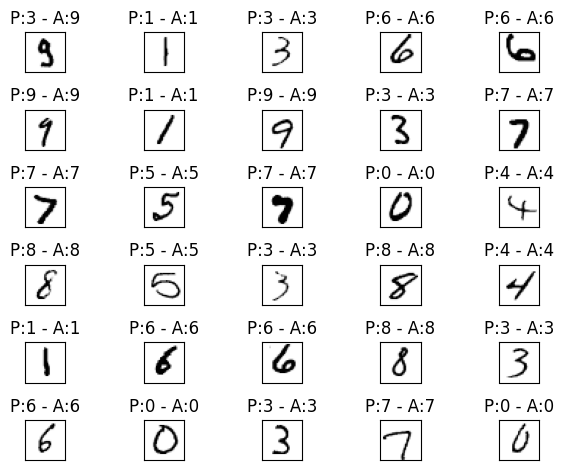

In [16]:
# plot the first 10 test images with their predicted labels
def plot_predictions(num_images: int = 10):
    fig, ax = plt.subplots(nrows=num_images // 5, ncols=5, sharex=True, sharey=True)
    ax = ax.flatten()
    rows = np.random.choice(X_test.shape[0], size=num_images, replace=False)
    for i, row in enumerate(rows):
        img = X_test[row].cpu().numpy().reshape(28, 28)
        ax[i].imshow(img, cmap='Greys')
        ax[i].set_title(f'P:{predicted[row]} - A:{y_test[row]}')
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    plt.tight_layout()
    #plt.savefig('figures/11_5.png', dpi=300)
    plt.show()

plot_predictions(num_images=30)

In [31]:
# calculate accuracy metrics on the test set
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support

print(f'Accuracy: {accuracy_score(y_test, predicted):.3f}')
print(f'Precision: {precision_score(y_test, predicted, average="macro"):.3f}')
print(f'Recall: {recall_score(y_test, predicted, average="macro"):.3f}')
print(f'F1: {f1_score(y_test, predicted, average="macro"):.3f}')
print('---')
print(f'Accuracy: {accuracy_score(y_test, predicted):.3f}')
print(f'Precision: {precision_score(y_test, predicted, average="weighted"):.3f}')
print(f'Recall: {recall_score(y_test, predicted, average="weighted"):.3f}')
print(f'F1: {f1_score(y_test, predicted, average="weighted"):.3f}')
print('---')

Accuracy: 0.968
Precision: 0.968
Recall: 0.968
F1: 0.968
---
Accuracy: 0.968
Precision: 0.969
Recall: 0.968
F1: 0.968
---


In [28]:
((y_test == 3)& (predicted == 3)).sum().item()

695

In [30]:
# manually calcualte recall for class 3
_class = 8
true_positives = ((y_test == _class) & (predicted == _class)).sum().item()
false_negatives = ((y_test == _class) & (predicted != _class)).sum().item()
print(f'Recall for class {_class}: {true_positives / (true_positives + false_negatives):.3f}')

Recall for class 8: 0.948


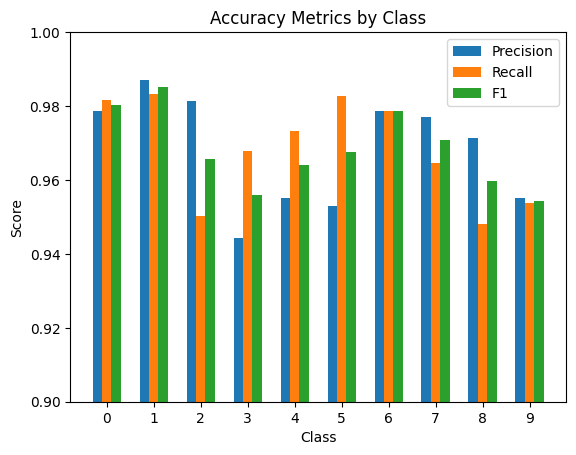

In [21]:
import matplotlib.pyplot as plt

# for each class calculate the accuracy metrics
precision, recall, f1, _ = precision_recall_fscore_support(y_test, predicted)

# create a bar plot
x = range(10)
width = 0.2

fig, ax = plt.subplots()
rects1 = ax.bar(x, precision, width, label='Precision')
rects2 = ax.bar([i + width for i in x], recall, width, label='Recall')
rects3 = ax.bar([i + 2 * width for i in x], f1, width, label='F1')

# add labels, title, and legend
ax.set_xlabel('Class')
ax.set_ylabel('Score')
ax.set_title('Accuracy Metrics by Class')
ax.set_xticks([i + width for i in x])
ax.set_xticklabels(range(10))
ax.legend()
# only show y ragen from 0.7 to 1.0
ax.set_ylim([0.9, 1.0])

# display the plot
plt.show()

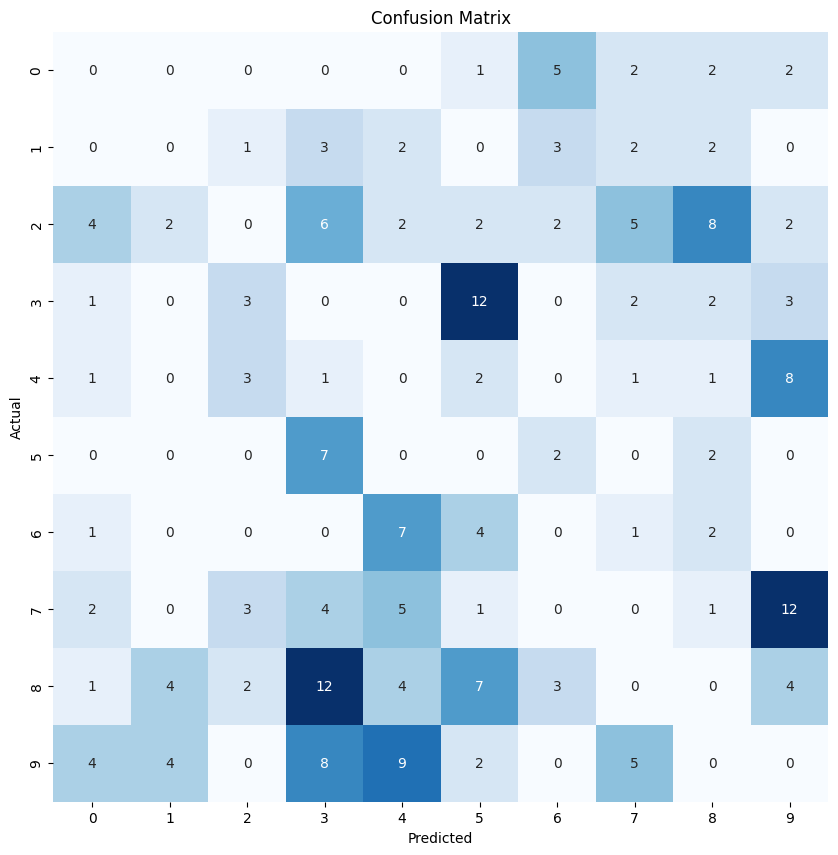

In [22]:
# create a heatmap of misclassified samples
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, predicted)
# remove the diagonal values for better visualization
np.fill_diagonal(cm, 0)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()